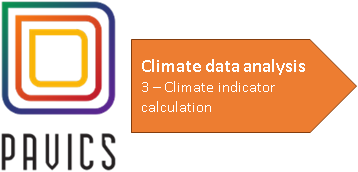
<a id='top'></a>

This third tutorial will demonstate PAVICS tools for calculating climate indicators, again accessing Ouranos' cb-oura-1.0 ensemble.  PAVICS incorporates the [xclim](https://xclim.readthedocs.io/en/stable/) library which essentially has two layers for the calculation of indicators. The first `xclim.indices` is a core layer and containing the various algorithms and calculation logic, as well as any potential unit conversions.  A second layer consists of `xclim.core.indicator.Indicator` instances that essentially perform the same computations found in `xclim.indices`, but also run a number of health checks on input data and assign attributes to the output arrays. Indicators are split into realms (`atmos`, `land`, `seaIce`), according to the variables they operate on. 

This tutorial uses [xclim's](https://xclim.readthedocs.io/en/stable/) `atmos` module outlining steps for:

* [Climate indicator calculation](#climcalc)
* [Missing data options](#missing)

Advanced topics:

* [Simple multiprocessing of an ensemble](#multiproc)

remove these
* [Comparison of `atmos` and `indices`](#compare)
* [Unit handling](#units)
* [French language metadata fields](#french)

We re-use part of the data-access and subset tutorials to select a dataset from cb-oura-1.0 datasets from the PAVICS THREDDS server.
___

*NOTE : To run this series of tutorials in the PAVICS jupyterhub, notebooks should be copied into your 'writable-workspace' directory*

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 84, time: 55115)
Coordinates:
  * lat      (lat) float32 48.96 48.87 48.79 48.71 ... 48.29 48.21 48.12 48.04
  * lon      (lon) float32 -69.96 -69.88 -69.8 -69.71 ... -63.21 -63.13 -63.05
  * time     (time) object 1950-01-01 00:00:00 ... 2100-12-31 00:00:00
Data variables:
    tasmin   (time, lat, lon) float32 dask.array<chunksize=(512, 12, 30), meta=np.ndarray>
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(512, 12, 30), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(512, 12, 30), meta=np.ndarray>
Attributes:
    Conventions:                CF-1.5
    title:                      Ouranos standard ensemble of bias-adjusted cl...
    history:                    2011-06-01T01:08:07Z CMOR rewrote data to com...
    institution:                Ouranos Consortium on Regional Climatology an...
    source:                     NorESM1-M 2011  atmosphere: CAM-Oslo (CAM4-Os...
    driving_model:              NorESM1-M
    driving_experiment:         historical,rcp85
    institute_id:               Ouranos
    type:                       GCM
    processing:                 bias_adjusted
    dataset_description:        https://www.ouranos.ca/publication-scientifiq...
    bias_adjustment_method:     1D-Quantile Mapping
    bias_adjustment_reference:  http://doi.org/10.1002/2015JD023890
    project_id:                 CMIP5
    licence_type:               permissive
    terms_of_use:               Terms of use at https://www.ouranos.ca/climat...
    attribution:                Use of this dataset should be acknowledged as...
    frequency:                  day
    modeling_realm:             atmos
    target_dataset:             CANADA : ANUSPLIN interpolated Canada daily 3...
    target_dataset_references:  CANADA : https://doi.org/10.1175/2011BAMS3132...
    driving_institution:        Norwegian Climate Centre
    driving_institute_id:       NCC

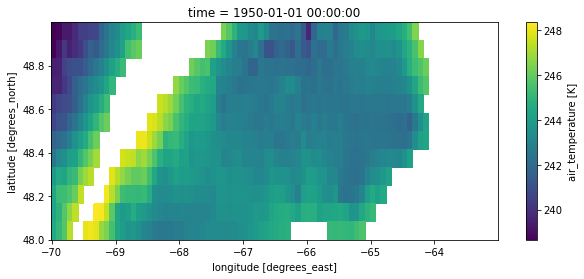

In [1]:
from siphon.catalog import TDSCatalog
from clisops.core import subset
import xarray as xr
# TODO change address
url = "http://pavics.ouranos.ca:8083/twitcher/ows/proxy/thredds/catalog/datasets/simulations/bias_adjusted/cmip5/ouranos/cb-oura-1.0/catalog.xml"

# Create Catalog
cat = TDSCatalog(url)

# Subset over the Gaspé peninsula in eastern Quebec
# This does not download the entire dataset, just the metadata and attributes describing the content. 
lon_bnds = [-70, -63]
lat_bnds = [48, 49]
ds = subset.subset_bbox(xr.open_dataset(cat.datasets[0].access_urls["OPENDAP"], chunks=dict(time=256*2, lat=32, lon=32)), lon_bnds=lon_bnds, lat_bnds=lat_bnds)

# What we see here is an in-memory representation of the full content, the actual data is still on the server.
display(ds)

# plot of single day tasmin
ds.tasmin.isel(time=0).plot(figsize=(10,4))

<a id='climcalc'></a>
### Climate indicator calculation
The `atmos` module allows us to easily calculate a large number of climate indicators. For example we can determine the projected the number of days with maximum temperature above a threshold for our test dataset using the `atmos.tx_days_above`.  The vast majority of `xclim.atmos` calculations employ a resample frequency parameter `freq` trivializing the calculation of yearly (`'YS'`), monthly (`'MS'`), seasonal (`'QS-DEC'`) or other custom outputs (for example `'6MS'` produces 6-month output    
*[return to top of page](#top)*

2021-02-11 11:19:20,856 - pint.util - WARNING - Redefining 'degree_Celsius' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,856 - pint.util - WARNING - Redefining '°C' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,857 - pint.util - WARNING - Redefining 'celsius' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,857 - pint.util - WARNING - Redefining 'degC' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,858 - pint.util - WARNING - Redefining 'degreeC' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,859 - pint.util - WARNING - Redefining 'C' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,859 - pint.util - WARNING - Redefining 'deg_C' (<class 'pint.definitions.UnitDefinition'>)
2021-02-11 11:19:20,860 - pint.util - WARNING - Redefining '[speed]' (<class 'pint.definitions.DimensionDefinition'>)
calculating yearly output using freq="YS"
[########################################] | 100% Complete

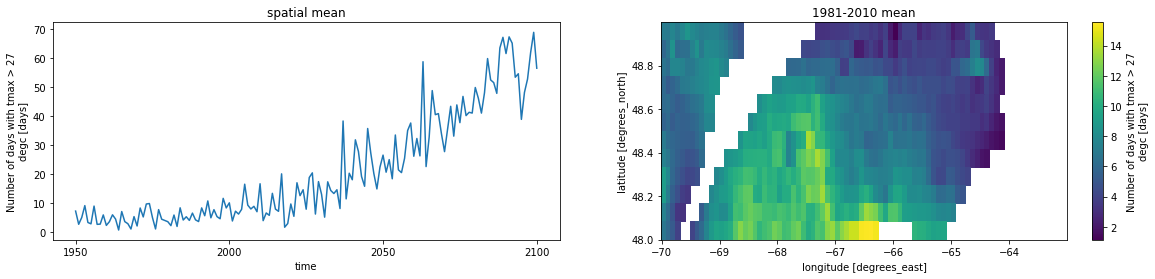

In [2]:
from xclim import atmos
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import warnings
warnings.simplefilter("ignore")

with ProgressBar():

    print(f'calculating yearly output using freq="YS"')
    out = atmos.tx_days_above(tasmax=ds.tasmax, thresh='27 degC', freq='YS') # Yearly frequency
    
    # Average over spatial domain and plot time-series
    fig1 = plt.figure(figsize=(20,4))
    plt.subplot(1,2,1)
    out.mean(dim=['lon','lat'], keep_attrs=True).plot()
    plt.title('spatial mean')
    
    # Calculate a 30 year climatology and plot a map
    plt.subplot(1,2,2)
    subset.subset_time(out, start_date='1981', end_date='2010').mean(dim='time', keep_attrs=True).plot()
    plt.title('1981-2010 mean')

___
<a id='missing'></a>
### Customizing climate indicator calculations
#### Missing data options
Some data sets require consideration of how best to deal with possible missing data in the input time-series. For example, The World Meteorological Organisation recommends that where monthly means are computed from daily values, it should considered missing if either of these two criteria are met:  observations are missing for 11 or more days during the month; observations are missing for a period of 5 or more consecutive days during the month.  Stricter criteria are sometimes used in practice, with a tolerance of 5 missing values or 3 consecutive missing values, or in other cases it is one may simply wish to use a percent value threshold 

The `xclim.set_options` can be used to choose from a number of [missing data options](https://xclim.readthedocs.io/en/stable/checks.html#missing-values-identification).  


*[return to top of page](#top)*

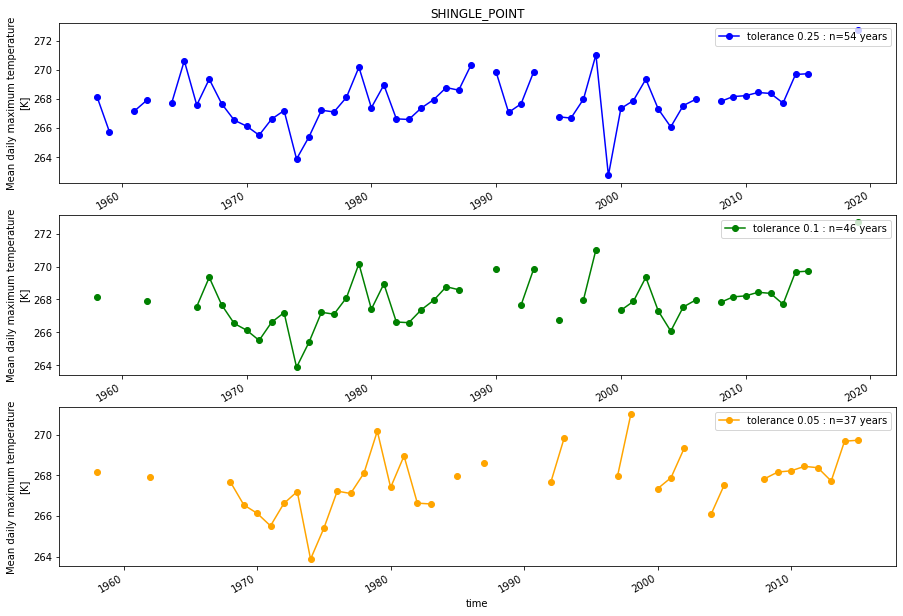

In [68]:
import xclim
# Access some station data
ds_stat = xr.open_dataset("https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/eccc/adjusted_homogenized_station_data/ahccd_gen3_tasmax.nc", chunks=dict(station=10))
istat = 10
# Compare use of differernt percent tolerance levels  (tolerance == 0.1)
plt.figure(figsize=(15,10))
color = ['blue','green','orange']
for i, tol in enumerate([0.25, 0.1, 0.05]):
    plt.subplot(3,1, i+1)
    with xclim.set_options(check_missing='pct', missing_options={'pct': {'tolerance': tol}}):
        
        tx_mean = xclim.atmos.tx_mean(tasmax=ds_stat.isel(station=istat).tasmax, freq='YS') # compute monthly max tasmax
        
        tx_mean.plot(marker='o', color=color[i], label=f"tolerance {tol} : {len(tx_mean.dropna('time').values)} years")
        plt.title('')
        plt.xlabel('')
        if i==0:
            plt.title(ds_stat.isel(station=istat).station_name.values)
        elif i==2:
            plt.xlabel('time')
    
        plt.legend(loc='upper right')

<a id='french'></a>
#### Adding french language metadata fields



*[return to top of page](#top)*

___
### Advanced Topics
<a id='multiproc'></a>
#### Simple multiprocessing of an ensemble
*[return to top of page](#top)*

ds_stat.sel(station=cond).tasmax

In [54]:
with xclim.set_options(check_missing='pct', missing_options={'pct': {'tolerance': 0.2}}):
    tx_mean = xclim.atmos.tx_mean(tasmax=ds_stat.isel(station=istat).tasmax, freq='YS')
tx_mean.dropna('time').time

<xarray.DataArray 'time' (time: 51)>
array(['1958-01-01T00:00:00.000000000', '1962-01-01T00:00:00.000000000',
       '1964-01-01T00:00:00.000000000', '1965-01-01T00:00:00.000000000',
       '1966-01-01T00:00:00.000000000', '1967-01-01T00:00:00.000000000',
       '1968-01-01T00:00:00.000000000', '1969-01-01T00:00:00.000000000',
       '1970-01-01T00:00:00.000000000', '1971-01-01T00:00:00.000000000',
       '1972-01-01T00:00:00.000000000', '1973-01-01T00:00:00.000000000',
       '1974-01-01T00:00:00.000000000', '1975-01-01T00:00:00.000000000',
       '1976-01-01T00:00:00.000000000', '1977-01-01T00:00:00.000000000',
       '1978-01-01T00:00:00.000000000', '1979-01-01T00:00:00.000000000',
       '1980-01-01T00:00:00.000000000', '1981-01-01T00:00:00.000000000',
       '1982-01-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1984-01-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1986-01-01T00:00:00.000000000', '1987-01-01T00:00:00.000000000',
       '1988-01-01T00:00:00.000000000', '1990-01-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1992-01-01T00:00:00.000000000',
       '1993-01-01T00:00:00.000000000', '1995-01-01T00:00:00.000000000',
       '1996-01-01T00:00:00.000000000', '1997-01-01T00:00:00.000000000',
       '1998-01-01T00:00:00.000000000', '2000-01-01T00:00:00.000000000',
       '2001-01-01T00:00:00.000000000', '2002-01-01T00:00:00.000000000',
       '2003-01-01T00:00:00.000000000', '2004-01-01T00:00:00.000000000',
       '2005-01-01T00:00:00.000000000', '2006-01-01T00:00:00.000000000',
       '2008-01-01T00:00:00.000000000', '2009-01-01T00:00:00.000000000',
       '2010-01-01T00:00:00.000000000', '2011-01-01T00:00:00.000000000',
       '2012-01-01T00:00:00.000000000', '2013-01-01T00:00:00.000000000',
       '2014-01-01T00:00:00.000000000', '2015-01-01T00:00:00.000000000',
       '2019-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time          (time) datetime64[ns] 1958-01-01 1962-01-01 ... 2019-01-01
    station       <U7 '2100950'
    stnid         object dask.array<chunksize=(), meta=np.ndarray>
    station_name  object dask.array<chunksize=(), meta=np.ndarray>